In [33]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
LOCAL_BASE_DIR = "/Users/georgiikuznetsov/Desktop/coding/CNN_nutrition/nutrition5k"
IMAGERY_DIR_LOCAL_FULL = os.path.join(LOCAL_BASE_DIR, "imagery/realsense_overhead")
METADATA_FILE_CAFE1 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe1.csv")
METADATA_FILE_CAFE2 = os.path.join(LOCAL_BASE_DIR, "metadata/dish_metadata_cafe2.csv")

assert(os.path.exists(LOCAL_BASE_DIR))
assert(os.path.exists(IMAGERY_DIR_LOCAL_FULL))
assert(os.path.exists(METADATA_FILE_CAFE1))
assert(os.path.exists(METADATA_FILE_CAFE2))

RGB_IMAGE_FILENAME = "rgb.png" 

In [35]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-2
NUM_EPOCHS = 5

In [36]:
TARGET_COLUMNS = ['calories', 'weight', 'fat', 'carbs', 'protein']

## LOADING DATA

In [37]:
def parse_nutrition_csv(file_path):
    dishes = []
    ingredients_list = []
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if not parts[0].startswith('dish_'):
                continue
                
            # Extract dish info (first 6 fields)
            dish_id = parts[0]
            dish_calories = float(parts[1])
            dish_weight = float(parts[2])
            dish_fat = float(parts[3])
            dish_carbs = float(parts[4])
            dish_protein = float(parts[5])
            
            dishes.append({
                'dish_id': dish_id,
                'calories': dish_calories,
                'weight': dish_weight,
                'fat': dish_fat,
                'carbs': dish_carbs,
                'protein': dish_protein
            })
            
            # Extract ingredients (in groups of 7 fields)
            ingredient_data = parts[6:]
            i = 0
            while i < len(ingredient_data) - 6:
                if not ingredient_data[i].startswith('ingr_'):
                    break
                    
                ingredients_list.append({
                    'dish_id': dish_id,
                    'ingredient_id': ingredient_data[i],
                    'ingredient_name': ingredient_data[i+1],
                    'amount': float(ingredient_data[i+2]),
                    'calories': float(ingredient_data[i+3]),
                    'fat': float(ingredient_data[i+4]),
                    'carbs': float(ingredient_data[i+5]),
                    'protein': float(ingredient_data[i+6])
                })
                i += 7
    
    # Create two separate dataframes
    dish_df = pd.DataFrame(dishes)
    ingredient_df = pd.DataFrame(ingredients_list)
    
    return dish_df, ingredient_df

In [38]:
dish_df_cafe1, ingredient_df_cafe1 = parse_nutrition_csv(METADATA_FILE_CAFE1)
dish_df_cafe2, ingredient_df_cafe2 = parse_nutrition_csv(METADATA_FILE_CAFE2)

if not dish_df_cafe1.empty and not dish_df_cafe2.empty:
    dish_metadata_df = pd.concat([dish_df_cafe1, dish_df_cafe2], ignore_index=True)
    ingredient_metadata_df = pd.concat([ingredient_df_cafe1, ingredient_df_cafe2], ignore_index=True)
elif not dish_df_cafe1.empty:
    dish_metadata_df = dish_df_cafe1
    ingredient_metadata_df = ingredient_df_cafe1
elif not dish_df_cafe2.empty:
    dish_metadata_df = dish_df_cafe2
    ingredient_metadata_df = ingredient_df_cafe2
else:
    raise Exception("No metadata files found or loaded. Please check paths.")

print("\n---DISHES---")
print(f"Combined dish metadata shape: {dish_metadata_df.shape}\n", dish_metadata_df.head())
print(dish_metadata_df.describe())
print("\n\n---INGREDIENTS---")
print(f"Combined ingredient metadata shape: {ingredient_metadata_df.shape}\n", ingredient_metadata_df.head())
print(ingredient_metadata_df.describe())


---DISHES---
Combined dish metadata shape: (5006, 6)
            dish_id    calories  weight        fat      carbs    protein
0  dish_1561662216  300.794281   193.0  12.387489  28.218290  18.633970
1  dish_1562688426  137.569992    88.0   8.256000   5.190000  10.297000
2  dish_1561662054  419.438782   292.0  23.838249  26.351543  25.910593
3  dish_1562008979  382.936646   290.0  22.224644  10.173570  35.345387
4  dish_1560455030   20.590000   103.0   0.148000   4.625000   0.956000
          calories       weight          fat        carbs      protein
count  5006.000000  5006.000000  5006.000000  5006.000000  5006.000000
mean    213.332125   189.980224    10.721587    17.002987    14.476484
std     308.762649   269.299511    24.455768    28.680633    18.561609
min       0.000000     1.000000     0.000000     0.000000     0.000000
25%      49.939999    73.000000     0.378500     4.338500     1.296000
50%     141.699997   145.000000     5.823762    11.801218     7.047808
75%     314.5187

In [39]:
available_dish_ids_in_imagery = []
if os.path.exists(IMAGERY_DIR_LOCAL_FULL):
    for dish_id_folder in os.listdir(IMAGERY_DIR_LOCAL_FULL):
        rgb_path = os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder, RGB_IMAGE_FILENAME)
        # Add a check for mask if MASKS_DIR is specified and used
        # mask_path_exists = True # Assume true if not using masks
        # if MASKS_DIR:
        #    mask_path = os.path.join(MASKS_DIR, dish_id_folder, dish_id_folder + MASK_IMAGE_FILENAME_SUFFIX)
        #    mask_path_exists = os.path.exists(mask_path)

        if os.path.isdir(os.path.join(IMAGERY_DIR_LOCAL_FULL, dish_id_folder)) and \
           os.path.exists(rgb_path): # and mask_path_exists:
            available_dish_ids_in_imagery.append(dish_id_folder)
else:
    print(f"Warning: Imagery directory {IMAGERY_DIR_LOCAL_FULL} not found.")

print(f"Found {len(available_dish_ids_in_imagery)} dish IDs with RGB images in the local imagery folder.")

Found 36 dish IDs with RGB images in the local imagery folder.


In [40]:
if not dish_metadata_df.empty:
    filtered_metadata_df = dish_metadata_df[dish_metadata_df['dish_id'].isin(available_dish_ids_in_imagery)].copy()
    print(f"Filtered dish metadata to {len(filtered_metadata_df)} dishes with available imagery.")
    
    for col in TARGET_COLUMNS: # Use original TARGET_COLUMNS for consistency
        filtered_metadata_df[col] = pd.to_numeric(filtered_metadata_df[col], errors='coerce')
    filtered_metadata_df.dropna(subset=TARGET_COLUMNS, inplace=True)
    print(f"Dish metadata after dropping NaNs in target columns: {len(filtered_metadata_df)} dishes.")

    # Prepare list of dish_ids and corresponding labels
    dish_ids_for_dataset = filtered_metadata_df['dish_id'].tolist()
    # Ensure labels are extracted using the original TARGET_COLUMNS order for the Dataset class
    labels_for_dataset = filtered_metadata_df[TARGET_COLUMNS].values.astype(np.float32)

    # Split into training and validation sets
    if len(dish_ids_for_dataset) > 1:
        train_dish_ids, val_dish_ids, train_labels, val_labels = train_test_split(
            dish_ids_for_dataset, labels_for_dataset, test_size=0.2, random_state=42
        )
        print(f"Training samples: {len(train_dish_ids)}, Validation samples: {len(val_dish_ids)}")
    else:
        print("Not enough data to create train/validation splits. Using all for training (if any).")
        train_dish_ids = dish_ids_for_dataset
        train_labels = labels_for_dataset
        val_dish_ids = []
        val_labels = np.array([])

    if train_dish_ids:
        print("\nSample training dish ID:", train_dish_ids[0])
        print("Sample training labels (matching TARGET_COLUMNS order):", train_labels[0])
else:
    print("No dish data available after parsing and filtering.")
    train_dish_ids, val_dish_ids, train_labels, val_labels = [], [], np.array([]), np.array([])

Filtered dish metadata to 36 dishes with available imagery.
Dish metadata after dropping NaNs in target columns: 36 dishes.
Training samples: 28, Validation samples: 8

Sample training dish ID: dish_1563395510
Sample training labels (matching TARGET_COLUMNS order): [415.6274   372.        19.100136  33.54165   34.771233]


In [41]:
class NutritionDataset(Dataset):
    def __init__(self, dish_ids, labels, imagery_dir, rgb_filename, mask_dir=None, mask_suffix=None, transform=None):
        self.dish_ids = dish_ids
        self.labels = labels
        self.imagery_dir = imagery_dir
        self.rgb_filename = rgb_filename
        self.mask_dir = mask_dir
        self.mask_suffix = mask_suffix
        self.transform = transform

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]
        
        # Load RGB image
        img_path = os.path.join(self.imagery_dir, dish_id, self.rgb_filename)
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_path} for dish_id {dish_id}")
            # Return a dummy image and label or raise error
            return torch.zeros(3, 224, 224), torch.zeros(len(TARGET_COLUMNS))


        # --- Apply Segmentation Mask ---
        # This is crucial for replicating Zhao et al.
        # For now, if no masks_dir is provided, we use the full image.
        # In a real implementation, you'd load your mask and apply it here.
        # if self.mask_dir and self.mask_suffix:
        #     mask_path = os.path.join(self.mask_dir, dish_id, dish_id + self.mask_suffix)
        #     try:
        #         mask = Image.open(mask_path).convert("L") # Grayscale mask
        #         mask = np.array(mask) / 255.0 # Normalize to 0-1
        #         mask = np.expand_dims(mask, axis=2) # Add channel dim for broadcasting
                
        #         image_np = np.array(image)
        #         segmented_image_np = image_np * mask # Element-wise multiplication
        #         image = Image.fromarray(segmented_image_np.astype(np.uint8))
        #     except FileNotFoundError:
        #         print(f"Warning: Mask not found at {mask_path} for dish {dish_id}. Using full image.")
        # else:
            # print(f"No mask directory specified for dish {dish_id}. Using full image.")


        if self.transform:
            image = self.transform(image)
        
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return image, label_tensor

# Define transformations
# ResNet101 expects 224x224 images, and specific normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)), # Resize larger then crop
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Optional
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)), # Direct resize for validation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Train dataset created with 28 samples.
Validation dataset created with 8 samples.

Testing DataLoader...
Sample input batch shape: torch.Size([8, 3, 224, 224])
Sample label batch shape: torch.Size([8, 5])


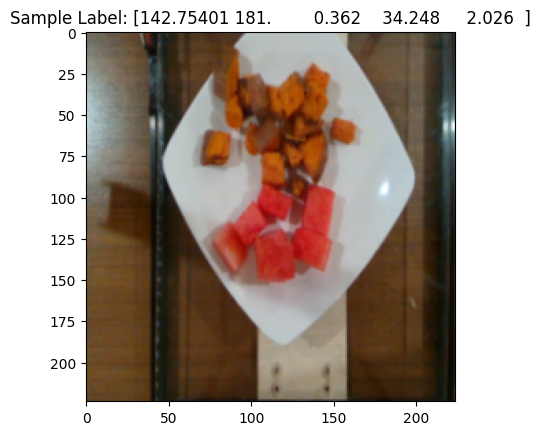

In [42]:
if train_dish_ids:
    train_dataset = NutritionDataset(
        dish_ids=train_dish_ids,
        labels=train_labels,
        imagery_dir=IMAGERY_DIR_LOCAL_FULL,
        rgb_filename=RGB_IMAGE_FILENAME,
        # mask_dir=MASKS_DIR, # Uncomment if you have masks
        # mask_suffix=MASK_IMAGE_FILENAME_SUFFIX, # Uncomment if you have masks
        transform=data_transforms['train']
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers > 0 for faster loading
    print(f"Train dataset created with {len(train_dataset)} samples.")
else:
    train_loader = None
    print("No training data available to create dataset.")

if val_dish_ids:
    val_dataset = NutritionDataset(
        dish_ids=val_dish_ids,
        labels=val_labels,
        imagery_dir=IMAGERY_DIR_LOCAL_FULL,
        rgb_filename=RGB_IMAGE_FILENAME,
        # mask_dir=MASKS_DIR, # Uncomment if you have masks
        # mask_suffix=MASK_IMAGE_FILENAME_SUFFIX, # Uncomment if you have masks
        transform=data_transforms['val']
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Validation dataset created with {len(val_dataset)} samples.")
else:
    val_loader = None
    print("No validation data available to create dataset.")

# --- Test the dataset and loader (optional) ---
if train_loader:
    print("\nTesting DataLoader...")
    try:
        sample_inputs, sample_labels = next(iter(train_loader))
        print("Sample input batch shape:", sample_inputs.shape) # Should be [BATCH_SIZE, 3, 224, 224]
        print("Sample label batch shape:", sample_labels.shape) # Should be [BATCH_SIZE, 5]
        
        # Visualize a sample image from the batch
        img_to_show = sample_inputs[0].permute(1, 2, 0).numpy() # CHW to HWC
        # Un-normalize for display (approximate)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_to_show = std * img_to_show + mean
        img_to_show = np.clip(img_to_show, 0, 1)
        
        plt.imshow(img_to_show)
        plt.title(f"Sample Label: {sample_labels[0].numpy()}")
        plt.show()
    except Exception as e:
        print(f"Error testing DataLoader: {e}")
        print("This might happen if your dataset is very small or image paths are incorrect.")

# idea is this:
get segmentated pictures (something to work on)
    |- >
        back_bone
            | ->
            Feature Enhancement
                | ->
                3x FC
